# Project: Cross-Asset Signals for FX Futures Trading

- **Course**: FINM 33150 Quantitative Trading Strategies
- **Due Date**: 07 March 2026
- **Group**: N
- **Researchers**:
    - Adith Srinivasan (adiths)
    - Andrew Moukabary (amoukabary)
    - Cole Koryto (koryto)
    - Jonathan Kim (jonathankim)
    - Scott Hanna (wshanna16)

# Preliminaries

Includes required package imports, global constants, and all function definitions. Collapsed for readability.

In [27]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from pathlib import Path

import plotnine as p9
p9.theme_set(p9.theme_gray())

from plotnine import *

import matplotlib as mpl
mpl.rcParams["figure.edgecolor"] = "none"
mpl.rcParams["savefig.transparent"] = True

import matplotlib.pyplot as plt
plt.rcdefaults()

In [23]:
START_DATE = "2024-01-01"
END_DATE = "2025-12-31"

In [24]:
DATA_DIR = Path("../data")
print(DATA_DIR)

../data


## Data Preparation

In [29]:
def prepare_equity_index_data(data: pd.DataFrame):

    data = data.copy()

    data = data.rename(columns={"Dates": "date"})

    data["date"] = pd.to_datetime(data["date"])
    data = data.set_index("date")

    data = data[
        (data.index > pd.to_datetime(START_DATE)) &
        (data.index < pd.to_datetime(END_DATE))
    ]

    data = data.ffill()
    data = data.dropna()

    return data

In [32]:
def plot_rebased_equity_indices(df: pd.DataFrame):
    # If your dates are the index (like in your screenshot), make it a column
    if df.index.name in ("date", "Dates") or isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()

    # Standardize column name
    if "Dates" in df.columns and "date" not in df.columns:
        df = df.rename(columns={"Dates": "date"})

    df["date"] = pd.to_datetime(df["date"])

    df_rebased = df.copy()
    for col in df.columns:
        if col != "date":
            df_rebased[col] = df[col] / df[col].iloc[0] * 100

    # Melt to long
    df_long = df_rebased.melt(id_vars="date", var_name="Index", value_name="Level")

    # Force numeric (handles strings, commas, weird Excel types)
    df_long["Level"] = pd.to_numeric(df_long["Level"], errors="coerce")

    # Drop unusable rows
    df_long = df_long.dropna(subset=["date", "Level"])

    # Plot
    p = (
        ggplot(df_long, aes(x="date", y="Level", color="Index"))
        + geom_line(size=1)
        + theme_minimal()
        + labs(
            title="Equity Indices Over Time",
            x="Date",
            y="Rebased Index Level (Base = 100)"
        )
        + theme(
            figure_size=(12,6),
            legend_title=element_text(size=10),
            legend_text=element_text(size=9)
        )
    )

    display(p)

# Abstract

This paper develops a two-stage framework to forecast exchange rate movements using credit and equity market information. In the first stage, exchange rate changes are regressed on foreign sovereign CDS spreads to remove the portion of currency movements driven by broad macro and risk conditions that affect both credit and FX markets. The resulting residual represents exchange rate variation not explained by these common macro factors.

In the second stage, this residual FX componen in regressed on excess foreign equity returns to isolate the equity-driven effect on currencies. The estimated relationship produces a trading signal, and currency futures positions are taken when the signal is sufficiently strong. The framework tests whether controlling for macro risk improves the predictive link between equity performance and exchange rate movements.

# Keywords

- Exchange rate predictability 
- Cross-asset return forecasting 
- Sovereign CDS spreads 
- Equity–FX linkage 
- Residual-based signal extraction 
- Currency futures 


# 1. Introduction

Global capital markets are highly interconnected, and cross-border flows of equity and credit capital can have substantial effects on exchange rates. Our strategy exploits the intuition that country-specific equity performance can provide predictive information about currency movements, once the influence of broad macroeconomic and global risk factors is removed. The underlying idea is that when investors reallocate capital in response to strong equity returns in a foreign market, they must transact in the local currency of that market. If these flows are sufficiently large or concentrated, they can drive meaningful movements in exchange rates.

However, exchange rates are influenced not only by equity-driven flows but also by macroeconomic and global risk factors that affect multiple asset classes simultaneously. For example, broad risk sentiment or systemic credit conditions can move both sovereign CDS spreads and currencies. To isolate the portion of FX movements specifically related to equity-driven capital flows, we introduce a two-stage regression framework.

In the first stage, we regress exchange rate changes on foreign sovereign CDS spreads. Sovereign CDS spreads are sensitive to macroeconomic and global risk conditions — including interest rate expectations, fiscal risk, and systemic shocks — which often simultaneously affect currency markets. By regressing FX on CDS, we remove the component of exchange rate movements that is correlated with these macro risk factors. The residual from this regression represents the portion of currency movements that is orthogonal to broad macro conditions, effectively filtering out “noise” from global risk factors and leaving the variation potentially attributable to other forces, such as equity-driven capital flows.

In the second stage, we regress the residual FX component against the excess foreign equity returns. The intuition is that equity performance can drive short-term currency demand through portfolio reallocation. If a country’s equities outperform relative to domestic and global markets, investors may increase exposure to that market, purchasing the local currency to execute their trades. By regressing the residual FX variation on excess equity returns, we identify the equity-driven signal that is not explained by broad macro factors. The fitted relationship from this stage serves as the trading signal in our strategy: positions in currency futures are initiated when the signal exceeds a predetermined threshold, reflecting a sufficiently strong equity-driven push on the currency.

Overall, our strategy integrates credit, equity, and FX markets into a unified predictive framework, exploiting the residual information in FX markets after conditioning on macro factors. It is designed to capture mispricings in currency futures driven by equity performance, while controlling for broader macro and risk-related influences that could confound the signal. By focusing on the portion of currency variation that is truly driven by equity performance, our approach aims to generate actionable signals with improved predictive power and reduced exposure to global shocks.

In [30]:
eqy = pd.read_excel(DATA_DIR / "equity_indices.xlsx", parse_dates=["Dates"])
eqy = prepare_equity_index_data(eqy)

eqy.head()

,MEXBOL Index,IBOV Index,JALSH Index,NKY Index,AS51 Index,SPTSX Index
date,,,,,,
2024-01-04,55406.96,131225.91,74522.49,33288.29,7494.098,20871.35
2024-01-05,56192.78,132022.92,74488.20,33377.42,7489.072,20937.55
2024-01-08,56175.68,132426.54,74103.23,33377.42,7451.548,21074.91
2024-01-09,55105.58,131446.59,73826.15,33763.18,7520.524,20970.98
2024-01-10,55318.67,130841.09,73586.98,34441.72,7468.459,20989.42


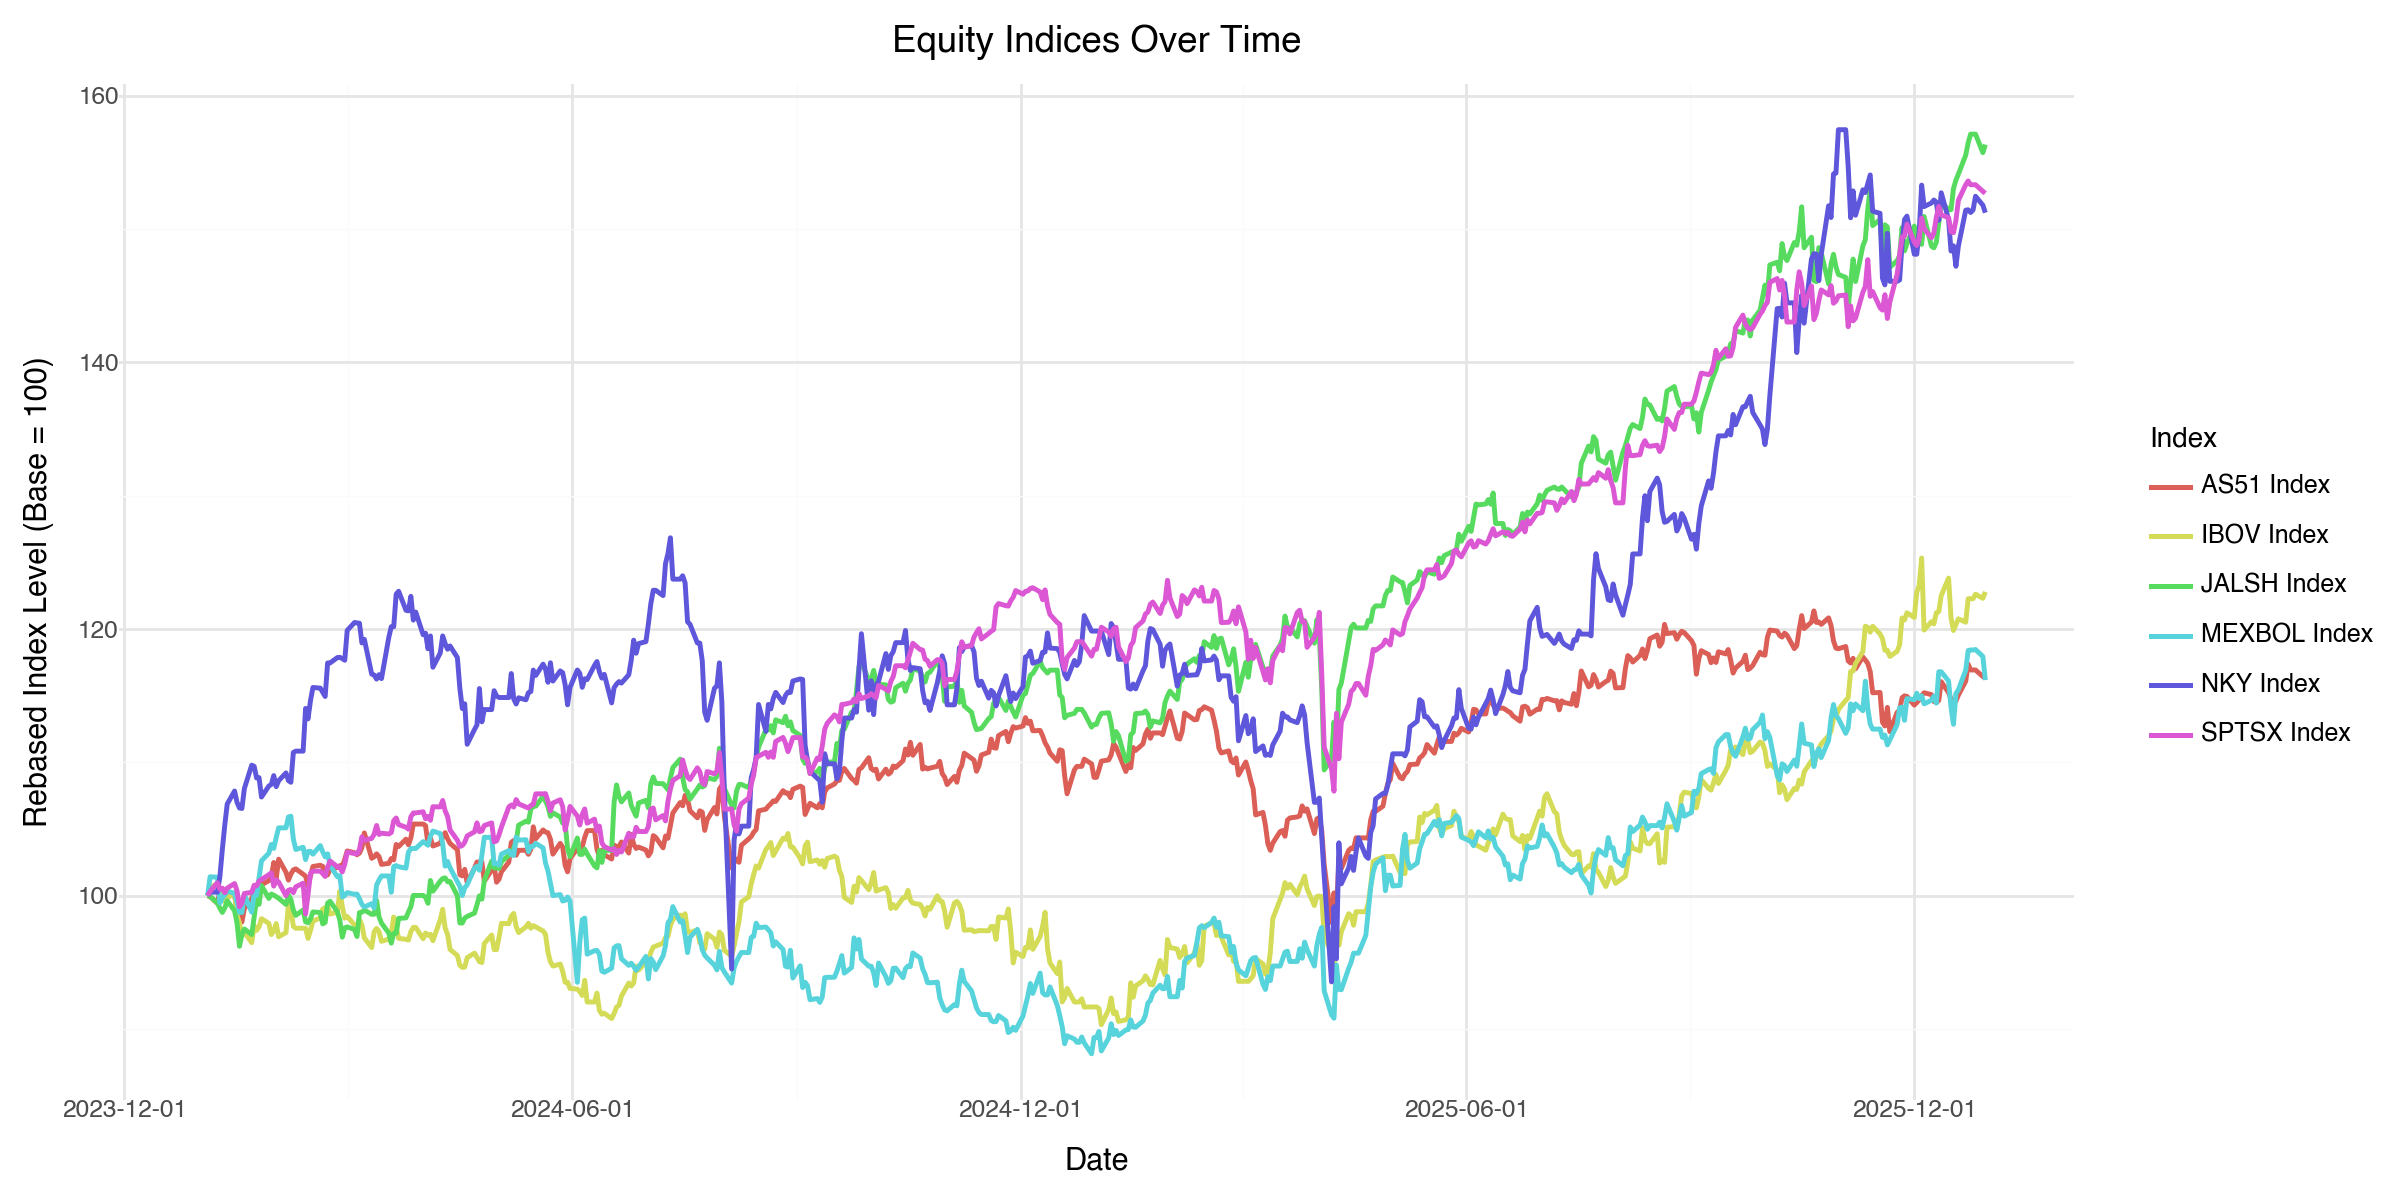

In [33]:
plot_rebased_equity_indices(eqy)

# 2. Trading Theory

Our strategy is grounded in two main trading hypotheses that reflect the cross-market dynamics between equity performance and currency movements, with particular attention to market liquidity and information flow.

### Hypothesis 1: Lead-Lag Relationship Between Equities and FX

The first hypothesis posits that a country’s major equities or stock indices exhibit a predictive relationship with the exchange rate of the corresponding currency, creating a lead-lag dynamic. The economic intuition stems from the portfolio reallocation mechanism:

- When domestic equities outperform relative to global markets, international investors seek exposure to capture the positive returns. Executing these transactions requires purchasing the local currency, generating demand that can drive appreciation.

- Equity markets often react faster to both domestic and global news than FX markets due to higher trading velocity, more immediate access to information, and higher concentration of informed participants. This difference in adjustment speed can create a predictable, short-term lead of equities over FX.

The lead-lag dynamic is reinforced by market microstructure frictions. FX markets, while large and liquid in aggregate, are fragmented, and institutional order execution may introduce delays in price adjustment. Moreover, large institutional investors may take more time to implement and execute rebalancing or investment ideas.

From a risk perspective, this lead-lag relationship reflects the fact that equities serve as an early signal of country-specific capital flow pressure. By monitoring excess returns in the equity market relative to macro-adjusted FX movements, we aim to extract a component of currency movements that is attributable specifically to anticipated capital flows, rather than broad macro shocks. This provides the foundation for a predictive signal in currency futures.

### Hypothesis 2: Lag Magnitude Depends on FX Market Liquidity
The second hypothesis extends the first by introducing a liquidity dimension. We expect that the observed lag between equity returns and FX adjustments will be longer in less liquid FX markets. The intuition for this hypothesis comes from the interaction of market microstructure and capital flow dynamics:

- In highly liquid FX markets (e.g., USD, EUR, JPY), large flows are more easily absorbed without significant price impact, and FX prices tend to adjust quickly to equity-driven demand. The lead-lag relationship is shorter and may be more difficult to exploit systematically.

- In less liquid markets, often associated with smaller economies or emerging markets, order flow from equity-driven capital reallocations can move exchange rates more slowly. FX participants may require time to absorb demand, and price discovery can be more gradual. This creates a longer and more exploitable lag in the relationship.

Liquidity effects also interact with investor behavior. In thin FX markets, foreign investors may need to stagger transactions to avoid excessive market impact, extending the time between equity signals and currency adjustment. Domestic investors, while facing lower transactional constraints, may still contribute to the lag if local FX depth is limited. Additionally, less liquid markets often exhibit higher transaction costs, wider bid-ask spreads, and more intermittent trading, all of which can amplify the persistence of the lead-lag dynamic.
